# Learning to estimate the unconditional density of a multivariate Gaussian distribution using MARVEL

In [1]:
import torch
from torch import nn
from src.marvel_loss import MARVEL
import lightning

import matplotlib.pyplot as plt

import numpy as np
from collections.abc import Iterable
from torch.distributions import Distribution
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

First we will create a dataset that generates samples from a mixture of two normal distributions. The dataset will also generate the latent space input for each sample. The latent space will be used to generate the samples. The dataset will be used to train a model that estimates the density of the samples.

In [2]:
class MixtureGeneratorDataset(Dataset):
    """Dataset for generating unconditional samples from a mixture of distributions.

    Args:
        latent_space_sampler (Distribution): A torch distribution from which to sample the latent space.
        length (int): The length of the dataset.
        ensemble_size (int): The number of samples to generate for each data point.
        latent_space_len (int): The length of the latent space.
        dist_weights (Iterable, optional): This list determines the weights of each sampler. If 2 locs and scales are
            given, and the parts is provided as (0.34, 0.66), then the values of the second sampler have twice the
            weight in the mixture. Defaults to tuple(1).
        sampler (Union[Distribution, list[Distribution]], optional): The samplers to use. If a list is provided, the
            length must be the same as the length of dist_weights. Defaults to None.
    """

    def __init__(
        self,
        latent_space_sampler: Distribution,
        length: int,
        ensemble_size: int,
        latent_space_len: int,
        sample_shape: int | list | tuple = 1,
        dist_weights: Iterable = (0.5, 0.5),
        sampler: Distribution | list[Distribution] = None,
    ):
        
        super().__init__()
        self.latent_space_sampler = latent_space_sampler
        self.length = length
        self.ensemble_size = ensemble_size
        self.latent_space_len = latent_space_len
        self.sample_shape = sample_shape if isinstance(sample_shape, (list, tuple)) else (sample_shape,)

        if not isinstance(sampler, Iterable):
            sampler = [sampler]
            dist_weights = [1]

        self.samplers = sampler

        assert sum(dist_weights) == 1, "The sum of parts must be 1."

        self.dist_weights = dist_weights

        self.y_data = torch.empty((self.length, *self.sample_shape))

        used_samples = 0
        for i, sampler in enumerate(self.samplers):
            this_part = int(self.length * self.dist_weights[i])

            self.y_data[used_samples : used_samples + this_part] = sampler.sample(
                sample_shape=(this_part, *self.sample_shape)
            )
            used_samples += this_part

        if used_samples < self.length:
            self.y_data[used_samples:] = self.samplers[-1].sample(
                sample_shape=(self.length - used_samples, *self.sample_shape)
            )

    def __getitem__(self, item):
        """Get a sample from the dataset.

        Args:
            item (int): The index of the sample.

        Returns:
            tuple: The sample, the target and the latent space. The target is the same as the sample and has shape
            (self.sample_shape).
        """
        latent_space = self.latent_space_sampler.sample(sample_shape=(self.ensemble_size, self.latent_space_len))
        y_data = self.y_data[item]

        return y_data, latent_space
    
    def __len__(self):
        return self.length

To initialize the dataset, we will create two normal distributions with different means and variances. 
We will then create a dataset that samples from these two distributions with a 70/30 ratio.

In [3]:
dataset = MixtureGeneratorDataset(sample_shape=1, 
                                  ensemble_size=1, 
                                  latent_space_len=20, 
                                  latent_space_sampler=torch.distributions.Normal(0, 1), 
                                  length=int(1e5), 
                                  sampler=[torch.distributions.Normal(-1, 1), 
                                                        torch.distributions.Normal(5, 0.3)], 
                                  dist_weights=[0.3, 0.7])

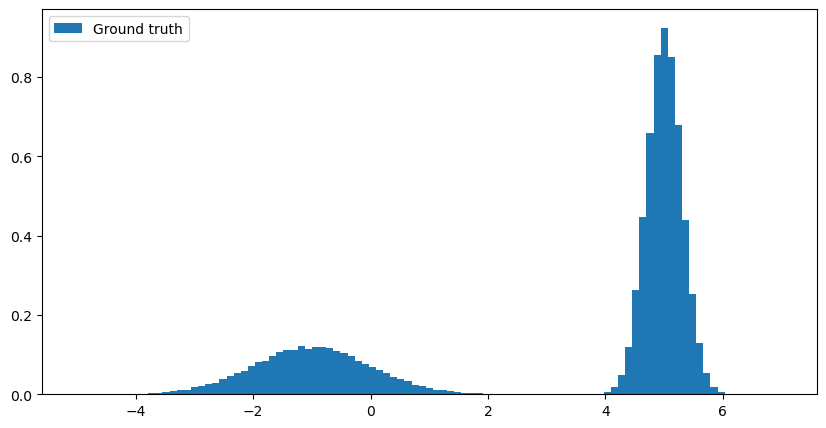

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(dataset.y_data.flatten(), bins=np.linspace(-5, 7, 100), label="Ground truth", density=True)
ax.legend(loc="upper left")
plt.show()

We will now define our neural network. It is nothing special, just a feedforward network with a few layers.

In [5]:
class UnconditionalFFWNet(nn.Module):
    def __init__(
        self, layers: list, activation: torch.nn.Module | None = None, batch_norm: bool = False, width: int = None, n_layers:int = None
    ):
        super().__init__()

        if activation is None:
            activation = nn.ReLU()

        if width is not None:
            if n_layers is not None:
                layers = [layers[0]] + [width] * n_layers + [layers[-1]]
            else:
                layers = [layers[0], width, layers[-1]]

        self._model = nn.Sequential()
        for i in range(len(layers) - 2):
            self._model.append(nn.Linear(layers[i], layers[i + 1]))
            if batch_norm:
                self._model.append(nn.BatchNorm1d(layers[i + 1]))
            self._model.append(activation)

        # Last layer
        self._model.append(nn.Linear(layers[-2], layers[-1]))

    def forward(self, noise):
        _model_out = self._model(noise)
        return _model_out


In [6]:
class NormalScaler:
    def __init__(self, data_mean, data_std):
        self.data_mean = data_mean
        self.data_std = data_std
        
    def transform(self, data):
        return (data - self.data_mean) / self.data_std
    
    def inverse_transform(self, data):
        return data * self.data_std + self.data_mean

In [7]:
lightning.seed_everything(41)

batch_size = 256  # 256 in the paper
ensemble_size = 256 # 256 in the paper
target_size = 1
latent_space_len = 20
training_steps = 20000
dataset_length = batch_size * training_steps

# initialize the dataset
dataset = MixtureGeneratorDataset(sample_shape=target_size, 
                                  ensemble_size=ensemble_size, 
                                  latent_space_len=latent_space_len, 
                                  latent_space_sampler=torch.distributions.Normal(0, 1), 
                                  length=dataset_length, 
                                  sampler=[torch.distributions.Normal(-1, 1), 
                                                        torch.distributions.Normal(5, 0.3)], 
                                  dist_weights=[0.3, 0.7])

# initialize the model. The first layer must be the same as the latent space size, the last layer must be the same as the target size.
model = UnconditionalFFWNet(layers=[latent_space_len, 64, 64, 64, 64, target_size], activation=nn.ReLU(), batch_norm=False)

# define the transformation function for the marvel loss. We will use the function exp(i * p * x) for the complex exponential.
func = ["lambda x, p: torch.exp(torch.complex(torch.tensor([0.]).type_as(x), torch.tensor([1.]).type_as(x)) * p * x)"]

fabric = lightning.Fabric()
fabric.launch()

dataset.y_data = dataset.y_data.to(fabric.device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader = fabric.setup_dataloaders(dataloader)

preprocessing = NormalScaler(data_mean=dataset.y_data.mean(), data_std=dataset.y_data.std())

loss_func = MARVEL(
    centralize=True,
    use_first_loss_term=True,
    use_random_loss_term=True,
    func=func,
    n_p_values_per_sample=10,
    random_power_max=20,
    random_power_min=0,
    random_power_warmup_steps=0,
    return_random_terms=False,
    random_loss_weight=1,
).to(fabric.device)


optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)
model, optimizer = fabric.setup(model, optimizer)

losses = []

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    y, latent = batch
    if preprocessing is not None:
        y = preprocessing.transform(y)
    optimizer.zero_grad()
    prediction = model(latent).view(ensemble_size, batch_size, target_size)
    
    loss = loss_func(prediction, y)["loss"]
    fabric.backward(loss)
    optimizer.step()
    losses.append(loss.item())
    
    if preprocessing is not None:
        prediction = preprocessing.inverse_transform(prediction)
        y = preprocessing.inverse_transform(y)
    
model = model.eval()

Seed set to 41


  0%|          | 0/20000 [00:00<?, ?it/s]

In [13]:
# lets validate the model by making some predictions and comparing them to the ground truth
val_steps = 100
val_dataset_length = batch_size * val_steps
val_dataset = MixtureGeneratorDataset(sample_shape=target_size, 
                                      ensemble_size=ensemble_size, 
                                      latent_space_len=latent_space_len, 
                                      latent_space_sampler=torch.distributions.Normal(0, 1), 
                                      length=val_dataset_length, 
                                      sampler=[torch.distributions.Normal(-1, 1), 
                                                        torch.distributions.Normal(5, 0.3)], 
                                      dist_weights=[0.3, 0.7])

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = fabric.setup_dataloaders(val_dataloader)

val_preds = []

for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
    y, latent = batch
    if preprocessing is not None:
        y = preprocessing.transform(y)
    prediction = model(latent).view(ensemble_size, batch_size, target_size)
    
    if preprocessing is not None:
        prediction = preprocessing.inverse_transform(prediction)
        y = preprocessing.inverse_transform(y)
    
    val_preds.append(prediction.detach().cpu())

  0%|          | 0/100 [00:00<?, ?it/s]

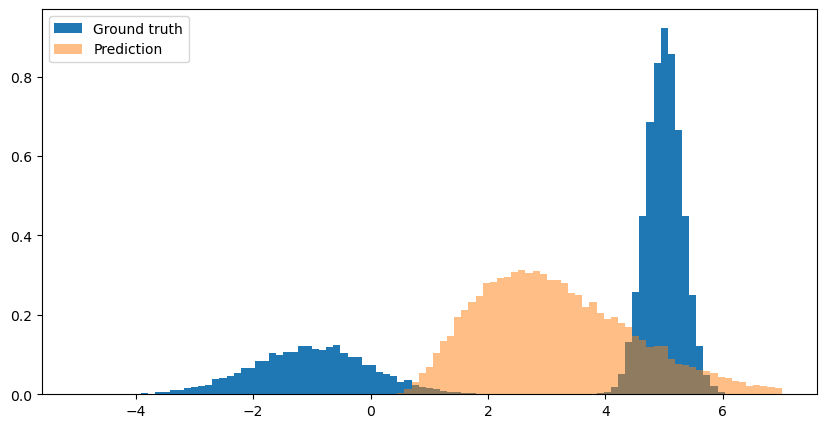

In [14]:
# plot the results

ground_truth_data = val_dataset.y_data.cpu().flatten().numpy()
prediction_data = torch.cat(val_preds, dim=1)[0].cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ground_truth_data, bins=np.linspace(-5, 7, 100), label="Ground truth", density=True)
ax.hist(prediction_data, bins=np.linspace(-5, 7, 100), label="Prediction", alpha=0.5, density=True)
ax.legend(loc="upper left")
plt.show()

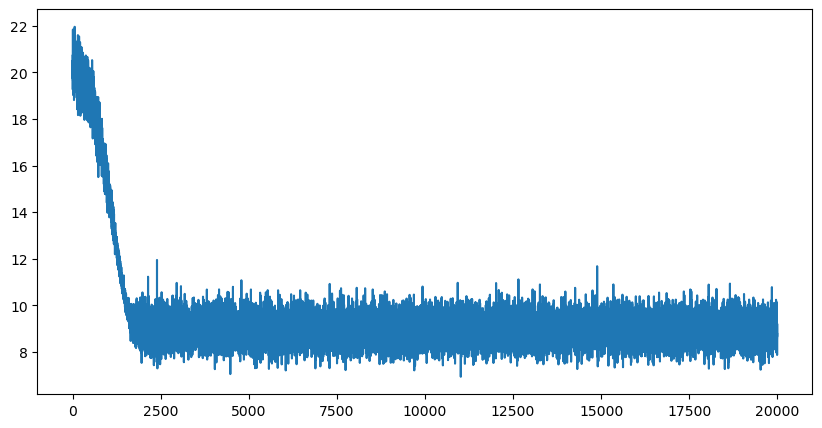

In [10]:
# plot the loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(losses)
plt.show()

In [11]:
len(val_dataset.y_data.flatten())

25600

In [12]:
ground_truth_data.shape

(25600,)